# Convolutional Neural Networks II

In [1]:
!pip install utils

## Model 1: Image Classification with the CIFAR-10 Dataset

In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

/Users/mattbrems/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/mattbrems/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = False
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [4]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
# Convert X data from ints to floats; scale to be between 0 and 1.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [6]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
model = Sequential()                              # Instantiate model.
model.add(Conv2D(32, (3, 3), padding='same',      # Specify (number of filters, filter size, padding size, input shape)
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))                     # Activation function to be used.
model.add(Conv2D(32, (3, 3)))                     # Specify tuple again. (padding default is 'valid' a.k.a. 0 padding)
model.add(Activation('relu'))                     # Activation function to be used.
model.add(MaxPooling2D(pool_size=(2, 2)))         # Pooling with filter size 2x2. (defaults to non-overlapping regions)
model.add(Dropout(0.25))                          # Dropout 25% of nodes randomly at each epoch.

In [8]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [9]:
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [10]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)  # RMSProp instead of gradient descent for optimization.

In [11]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [12]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
  576/50000 [..............................] - ETA: 4:04 - loss: 2.3077 - acc: 0.1076

KeyboardInterrupt: 

In [13]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/mattbrems/Documents/Documents/GA/DSI-EC-2/7-week/7.06-cnn-ii/solution-code/saved_models/keras_cifar10_trained_model.h5 


In [14]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 13s 1ms/step
Test loss: 2.3004964290618894
Test accuracy: 0.1003


In [15]:
model.summary() # Check out summary of model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

## Model 2: Forecasting the Stock Market using the Stock Market

In [16]:
from utils import *

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import Adam
from keras.initializers import *

from sklearn.model_selection import train_test_split

import seaborn as sns
sns.despine()

In [17]:
data_original = pd.read_csv('../AAPL1216.csv')[::-1]

In [18]:
data_original.head()

,Date,Open,High,Low,Close,Volume,Adj Close
1005,2012-01-03,409.399998,412.499989,408.999989,411.230000,75555200,53.278774
1004,2012-01-04,410.000011,414.680012,409.279995,413.440010,65005500,53.565102
1003,2012-01-05,414.950005,418.550007,412.670006,418.029995,67817400,54.159778
1002,2012-01-06,419.770008,422.749996,419.220009,422.400002,79573200,54.725955
1001,2012-01-09,425.499992,427.750004,421.349991,421.730000,98506100,54.639149


In [19]:
## Preprocessing

openp = data_original.loc[:, 'Open'].tolist()
highp = data_original.loc[:, 'High'].tolist()
lowp = data_original.loc[:, 'Low'].tolist()
closep = data_original.loc[:, 'Adj Close'].tolist()
volumep = data_original.loc[:, 'Volume'].tolist()
data_chng = data_original.loc[:, 'Adj Close'].pct_change().dropna().tolist()

In [20]:
WINDOW = 30
EMB_SIZE = 6  # "Embedding size" a.k.a. input size
STEP = 1
FORECAST = 1

X, Y = [], []

In [21]:
for i in range(0, len(data_original), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]
        d = data_chng[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)
        d = (np.array(d) - np.mean(d)) / np.std(d)

        x_i = closep[i:i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]  

        last_close = x_i[-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

        x_i = np.column_stack((o, h, l, c, v, d))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

In [22]:
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.25, 
                                                    random_state = 42)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [23]:
model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        filters = 16,
                        kernel_size = 4,
                        padding = 'same'))
model.add(BatchNormalization()) ## speeds up computation by normalizing
                                ## outputs from previous layer
model.add(LeakyReLU())
model.add(Dropout(0.5))

In [24]:
model.add(Convolution1D(filters = 8,
                        kernel_size = 4,
                        padding = 'same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

In [25]:
model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

In [26]:
model.add(Dense(2))
model.add(Activation('softmax'))

In [27]:
model.compile(optimizer = 'adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, 
          epochs = 100, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

Train on 731 samples, validate on 244 samples
Epoch 1/100
731/731 [==============================] - 1s 2ms/step - loss: 0.9463 - acc: 0.5376 - val_loss: 0.7565 - val_acc: 0.4795
Epoch 2/100
731/731 [==============================] - 0s 104us/step - loss: 0.8498 - acc: 0.5513 - val_loss: 0.7280 - val_acc: 0.4959
Epoch 3/100
731/731 [==============================] - 0s 175us/step - loss: 0.7870 - acc: 0.5540 - val_loss: 0.7109 - val_acc: 0.5205
Epoch 4/100
731/731 [==============================] - 0s 147us/step - loss: 0.7277 - acc: 0.5869 - val_loss: 0.7053 - val_acc: 0.5410
Epoch 5/100
731/731 [==============================] - 0s 120us/step - loss: 0.7332 - acc: 0.5787 - val_loss: 0.7060 - val_acc: 0.5451
Epoch 6/100
731/731 [==============================] - 0s 144us/step - loss: 0.6727 - acc: 0.5882 - val_loss: 0.7036 - val_acc: 0.5574
Epoch 7/100
731/731 [==============================] - 0s 142us/step - loss: 0.7036 - acc: 0.5882 - val_loss: 0.6964 - val_acc: 0.5369
Epoch 8/100

Epoch 61/100
731/731 [==============================] - 0s 143us/step - loss: 0.5063 - acc: 0.7647 - val_loss: 0.5278 - val_acc: 0.7213
Epoch 62/100
731/731 [==============================] - 0s 133us/step - loss: 0.4761 - acc: 0.7702 - val_loss: 0.5318 - val_acc: 0.7295
Epoch 63/100
731/731 [==============================] - 0s 133us/step - loss: 0.4804 - acc: 0.7483 - val_loss: 0.5334 - val_acc: 0.7172
Epoch 64/100
731/731 [==============================] - 0s 134us/step - loss: 0.5120 - acc: 0.7469 - val_loss: 0.5333 - val_acc: 0.7172
Epoch 65/100
731/731 [==============================] - 0s 138us/step - loss: 0.5025 - acc: 0.7579 - val_loss: 0.5359 - val_acc: 0.7049
Epoch 66/100
731/731 [==============================] - 0s 138us/step - loss: 0.5009 - acc: 0.7442 - val_loss: 0.5405 - val_acc: 0.7008
Epoch 67/100
731/731 [==============================] - 0s 140us/step - loss: 0.5196 - acc: 0.7469 - val_loss: 0.5443 - val_acc: 0.7049
Epoch 68/100
731/731 [==========================

In [28]:
# Make predictions.
pred = model.predict(np.array(X_test))

In [29]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print(["TN", "FP"])
print(["FN", "TP"])
print()
print(C / C.astype(np.float).sum())

['TN', 'FP']
['FN', 'TP']

[[0.34836066 0.15983607]
 [0.11885246 0.37295082]]


<Figure size 432x288 with 0 Axes>

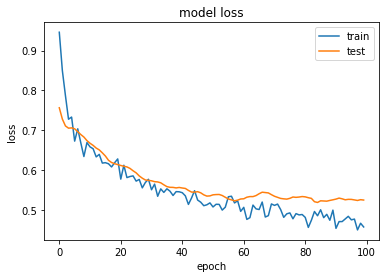

In [30]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best') ## I love this loc = 'best' command.
plt.show();

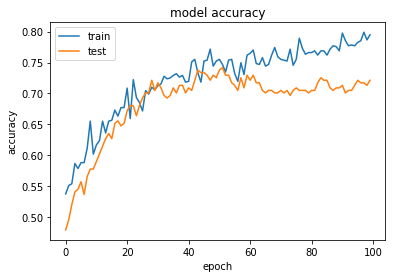

In [31]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

<details> <summary> How might we improve the performance of this model?
</summary>
```
- Our test error looks as though it's leveled off, but it's possible we're in a local minimum. If so, our model would be suffering from some error due to bias. We can account for that by:
    - increasing the number of epochs.
    - building a deeper network.
    - regularizing less than we are now (perhaps dropout is inflating our bias, for example).
    - adding more features!
    - If we try these things and our model continually performs worse, then we have evidence that our model is at risk of overfitting, so we wouldn't want to make our model more complex.
- We might also return to "standard" classification techniques:
    - consider changing our threshold for predicting "yes."
    - we might want to optimize for specificity or sensitivity.
    - luckily our classes look balanced, so no adjustment is needed there.
```
</details>

<details> <summary> What changes would I make to turn this into a regression problem?
</summary>
```
- Instead of predicting Y in {higher, lower}, we want to predict the change in the price, which can *theoretically* be anywhere between negative infinity and positive infinity.
    - Change the output layer to only have one node.
    - Change the final activation function to be linear.
- Note: It'll be easier for us to predict higher versus lower than to predict the exact amount of change in a stock price.
```
</details>